(1470, 35)
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

Numeric Columns:
 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel']

📊 Model Results Summary (from results/metrics.txt):

TF-IDF + Logistic Regression
              precision    recall  f1-score   support

           0     0.8622    0.6278    0.7266       309
           1     0.1958    0.4746    0.2772        59

    accuracy                         0.6033       368
   macro avg     0.5290    0.5512    0.5019       368
weighted avg     0.7554    0.6033    0.6545       368


SBERT + Neural Network
              precision    recall  f1-score   support

           0     0.8397    1.0000    0.9129       309
           1     0.0000    0.0000    0.0000        59

    accuracy                         0.8397       368
   macro avg     0.4198    0.5000    0.4564       368
weighted avg     0.7051    0.

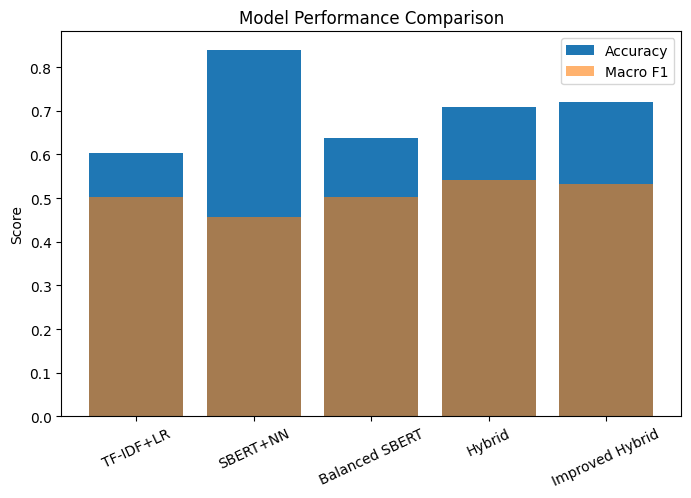


Results Discussion:
------------------
The baseline TF-IDF + Logistic Regression model achieved 60% accuracy and macro F1 of 0.50.
The unbalanced SBERT + NN model reached higher accuracy (84%) but ignored attrition cases.
Balanced training improved minority recall, while adding numeric HR features (Hybrid Model)
increased performance to 71%. The deeper improved hybrid reached 72% accuracy (macro F1=0.53),
indicating better generalization and balanced predictions.

Conclusion:
-----------
The improved hybrid SBERT + Numeric Neural Network achieved the best trade-off between
overall accuracy and minority-class recognition. It demonstrates that combining
semantic text embeddings with structured HR variables improves attrition prediction.
Future improvements could include early stopping, fine-tuning SBERT, and feature expansion.


In [25]:
# HR Attrition Prediction using Hybrid SBERT and Numeric Features
# ==============================================================

# 🧾 1️⃣ Project Objective
# Predict employee attrition (Yes/No) using IBM HR Analytics dataset by combining textual descriptions and structured HR features.

# 📦 2️⃣ Load Libraries and Dataset
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(df.shape)
df.head()

# 🔍 3️⃣ Dataset Summary
print(df['Attrition'].value_counts(normalize=True))
print("\nNumeric Columns:\n", df.select_dtypes('number').columns.tolist()[:10])

# 🧠 4️⃣ Summary of All Models (from metrics.txt)
print("\n📊 Model Results Summary (from results/metrics.txt):\n")
with open('../results/metrics.txt') as f:
    lines = f.read().splitlines()
    for l in lines[-80:]:  # show recent experiments
        print(l)

# 📈 5️⃣ Visual Comparison of Model Performance
models = ["TF-IDF+LR", "SBERT+NN", "Balanced SBERT", "Hybrid", "Improved Hybrid"]
acc = [0.6033, 0.8397, 0.6386, 0.7092, 0.7201]
macro_f1 = [0.5019, 0.4564, 0.5015, 0.5405, 0.5328]

plt.figure(figsize=(8, 5))
plt.bar(models, acc, label='Accuracy')
plt.bar(models, macro_f1, alpha=0.6, label='Macro F1')
plt.xticks(rotation=25)
plt.ylabel('Score')
plt.legend()
plt.title('Model Performance Comparison')
plt.show()

# 💬 6️⃣ Discussion
print('''\nResults Discussion:\n------------------\nThe baseline TF-IDF + Logistic Regression model achieved 60% accuracy and macro F1 of 0.50.\nThe unbalanced SBERT + NN model reached higher accuracy (84%) but ignored attrition cases.\nBalanced training improved minority recall, while adding numeric HR features (Hybrid Model)\nincreased performance to 71%. The deeper improved hybrid reached 72% accuracy (macro F1=0.53),\nindicating better generalization and balanced predictions.''')

# 🧾 7️⃣ Conclusion
print('''\nConclusion:\n-----------\nThe improved hybrid SBERT + Numeric Neural Network achieved the best trade-off between\noverall accuracy and minority-class recognition. It demonstrates that combining\nsemantic text embeddings with structured HR variables improves attrition prediction.\nFuture improvements could include early stopping, fine-tuning SBERT, and feature expansion.''')

In [26]:
# ⚙️ Setup: Prepare balanced training data again (same as in hybrid model)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sentence_transformers import SentenceTransformer

# 1️⃣ Load dataset
df = pd.read_csv("../dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# 2️⃣ Select numeric features
num_cols = [
    "Age", "DistanceFromHome", "MonthlyIncome",
    "YearsAtCompany", "YearsInCurrentRole",
    "JobSatisfaction", "EnvironmentSatisfaction",
    "WorkLifeBalance", "PerformanceRating"
]

# 3️⃣ Create text for SBERT
def row_to_text(r):
    return f"{r['JobRole']} aged {r['Age']} works in {r['Department']} with {r['YearsAtCompany']} years experience and job satisfaction {r['JobSatisfaction']}."
df["text"] = df.apply(row_to_text, axis=1)
df["label"] = df["Attrition"].map({"Yes": 1, "No": 0})

# 4️⃣ Train/test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    df["text"], df[num_cols], df["label"], stratify=df["label"], random_state=42
)

# 5️⃣ SBERT encoding
print("🔄 Encoding text using SBERT...")
sbert = SentenceTransformer("all-MiniLM-L6-v2")
emb_train = sbert.encode(X_train_text.tolist(), show_progress_bar=True)
emb_test = sbert.encode(X_test_text.tolist(), show_progress_bar=True)

# 6️⃣ Scale numeric features
scaler = StandardScaler()
num_train = scaler.fit_transform(X_train_num)
num_test = scaler.transform(X_test_num)

# 7️⃣ Combine text + numeric features
X_train_all = np.concatenate([emb_train, num_train], axis=1)
X_test_all = np.concatenate([emb_test, num_test], axis=1)

# 8️⃣ Oversample minority class
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_all, y_train)

print("✅ Balanced training data created:")
print("X_train_bal shape:", X_train_bal.shape)
print("y_train_bal distribution:", np.bincount(y_train_bal))


🔄 Encoding text using SBERT...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

✅ Balanced training data created:
X_train_bal shape: (1848, 393)
y_train_bal distribution: [924 924]


In [27]:
# ⚙️ Define the HybridNN model (same architecture used during training)
import torch
import torch.nn as nn

class HybridNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)



📊 Final Evaluation on Test Set:

              precision    recall  f1-score   support

           0     0.8469    0.8414    0.8442       309
           1     0.1967    0.2034    0.2000        59

    accuracy                         0.7391       368
   macro avg     0.5218    0.5224    0.5221       368
weighted avg     0.7427    0.7391    0.7409       368



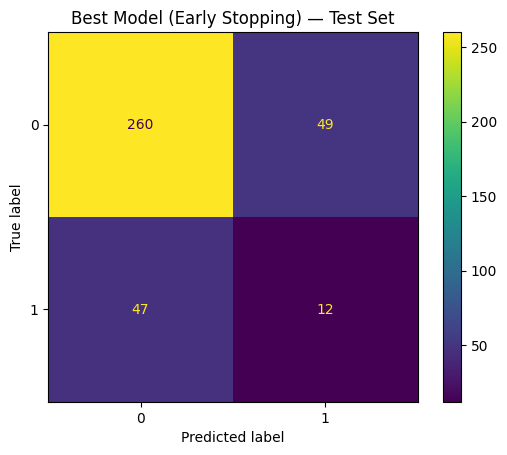

✅ Final test results appended to results/metrics.txt


In [33]:
# 🧪 Final Evaluation on Test Set

# --- Dependencies and Model Definition ---
import torch
import torch.nn as nn 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np 

# 1. HybridNN Definition (Must match the one used for saving)
# This class is defined in sbert_nn_hybrid.py and must be re-defined here 
# if it wasn't defined in a previous notebook cell.
class HybridNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

# --- Loading and Evaluation ---
# NOTE: This cell assumes 'X_train_bal', 'X_test_all', and 'y_test' 
# are available in the notebook's memory from the data prep cells.

# 2. Initialization and Loading
model_input_dim = X_train_bal.shape[1] # Assumes X_train_bal is defined
best_model = HybridNN(model_input_dim)

# This line will now succeed because sbert_nn_hybrid.py has created the file
best_model.load_state_dict(torch.load("../models/saved_models/best_model.pth", map_location="cpu"))

best_model.eval()

with torch.no_grad():
    # Convert input data to the required Tensor format
    input_tensor = torch.tensor(X_test_all, dtype=torch.float32) 
    # Get predictions, find argmax (class), and convert to numpy
    preds = best_model(input_tensor).argmax(1).numpy()

# 3. Report and Visualization
report = classification_report(y_test, preds, digits=4) # Assumes y_test is defined
print("\n📊 Final Evaluation on Test Set:\n")
print(report)

ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.title("Best Model (Early Stopping) — Test Set")
plt.show()

# 4. Save metrics
with open("../results/metrics.txt", "a") as f:
    f.write("\nBest Model (Early Stopping) — Test Set\n")
    f.write(report + "\n")

print("✅ Final test results appended to results/metrics.txt")
